In [5]:
%load_ext google.cloud.bigquery

In [32]:
import pandas as pd
import lightgbm

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from hm_fashion.model import get_lgm_ranker_pipeline

In [2]:
pd.options.display.float_format = "{:.2f}".format

## Load Training Data

In [6]:
%%bigquery training_data --project zenscr-seefood-dev

SELECT 
    t.obs_dat,
    t.customer_id,
    article_id,
    rank,
    relevance,
    feat_price_affinity,
    feat_dark_affinity,
    feat_dusty_light_affinity
FROM hm_kaggle_reco.training_data_sample t
LEFT JOIN hm_kaggle_reco.feat_customer fc
       ON t.obs_dat = fc.obs_dat AND t.customer_id = fc.customer_id
ORDER BY customer_id, relevance DESC

Downloading: 100%|████████████████████| 9288179/9288179 [00:21<00:00, 424911.16rows/s]


In [7]:
with pd.option_context("display.max_colwidth", -1):
    display(training_data)

,obs_dat,customer_id,article_id,rank,relevance,feat_price_affinity,feat_dark_affinity,feat_dusty_light_affinity
0,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f39a3aabda9dacaea176,699923099,16,1,0.03,0.62,0.12
1,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f39a3aabda9dacaea176,656868001,52,1,0.03,0.62,0.12
2,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f39a3aabda9dacaea176,575347003,17,1,0.03,0.62,0.12
3,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f39a3aabda9dacaea176,730013007,-1,1,0.03,0.62,0.12
4,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f39a3aabda9dacaea176,609485015,15,1,0.03,0.62,0.12
...,...,...,...,...,...,...,...,...
9288174,2020-04-01,fff2c4204fac63f93aec10ed657958d372efe948de1492e451e23d6e0be4a3c0,759814012,97,0,0.02,0.53,0.23
9288175,2020-04-01,fff2c4204fac63f93aec10ed657958d372efe948de1492e451e23d6e0be4a3c0,810231001,90,0,0.02,0.53,0.23
9288176,2020-04-01,fff2c4204fac63f93aec10ed657958d372efe948de1492e451e23d6e0be4a3c0,731710001,80,0,0.02,0.53,0.23
9288177,2020-04-01,fff2c4204fac63f93aec10ed657958d372efe948de1492e451e23d6e0be4a3c0,755575003,66,0,0.02,0.53,0.23


In [8]:
training_data[lambda d: d["customer_id"] == "0004ee708acad44b15ee324daffef7b379a1fdfd9826f39a3aabda9dacaea176"].head(20)

,obs_dat,customer_id,article_id,rank,relevance,feat_price_affinity,feat_dark_affinity,feat_dusty_light_affinity
0,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,699923099,16,1,0.03,0.62,0.12
1,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,656868001,52,1,0.03,0.62,0.12
2,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,575347003,17,1,0.03,0.62,0.12
3,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,730013007,-1,1,0.03,0.62,0.12
4,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,609485015,15,1,0.03,0.62,0.12
5,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,747899001,-1,1,0.03,0.62,0.12
6,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,685811002,35,0,0.03,0.62,0.12
7,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,825109001,34,0,0.03,0.62,0.12
8,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,790904003,13,0,0.03,0.62,0.12
9,2020-04-01,0004ee708acad44b15ee324daffef7b379a1fdfd9826f3...,767754004,12,0,0.03,0.62,0.12


In [9]:
training_data.isna().mean()

obs_dat                     0.00
customer_id                 0.00
article_id                  0.00
rank                        0.00
relevance                   0.00
feat_price_affinity         0.13
feat_dark_affinity          0.13
feat_dusty_light_affinity   0.13
dtype: float64

## Explore Training Data

In [10]:
training_data["relevance"].value_counts()

0    9267795
1      20384
Name: relevance, dtype: Int64

In [11]:
training_data["rank"].describe()

count   9288179.00
mean        105.78
std          41.71
min          -1.00
25%          82.00
50%         115.00
75%         141.00
max         159.00
Name: rank, dtype: float64

<AxesSubplot:ylabel='Frequency'>

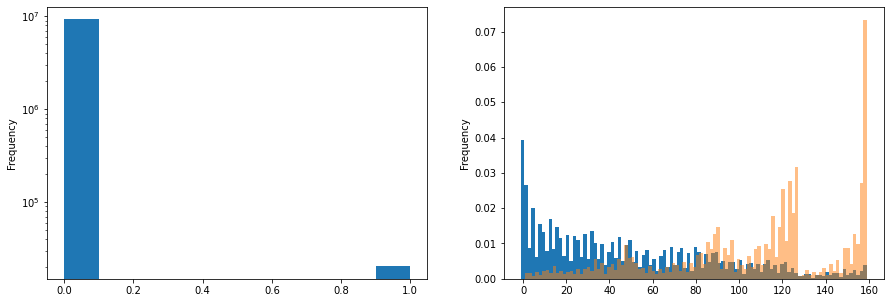

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

training_data["relevance"].plot.hist(log=True, ax=axs[0])

training_data[lambda d: d["relevance"] == 1]["rank"].plot.hist(density=True, bins=100, ax=axs[1])
training_data[lambda d: d["relevance"] == 0]["rank"].plot.hist(density=True, alpha=0.5, bins=100, ax=axs[1])

In [13]:
training_data[lambda d: d["relevance"] == 1]["rank"].map(lambda r: 1 if r == -1 else 0).value_counts()

0    19106
1     1278
Name: rank, dtype: int64

<AxesSubplot:ylabel='Frequency'>

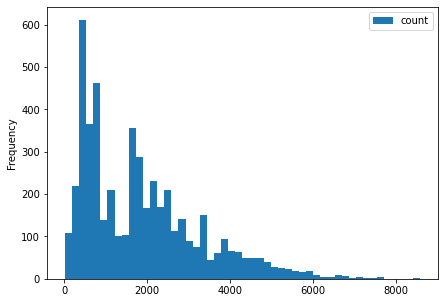

In [14]:
training_data.groupby("customer_id").agg(count=("article_id", "count")).plot.hist(bins=50, figsize=(7, 5))

## Model Training

In [15]:
pipe = get_lgm_ranker_pipeline()

In [22]:
model = pipe[-1]

In [21]:
pipe

Pipeline(steps=[('features',
                 Pipeline(steps=[('to_dataframe',
                                  FunctionTransformer(func=<function to_dataframe at 0x12fa0faf0>,
                                                      kw_args={'col_labels': ['feat_price_affinity',
                                                                              'feat_dark_affinity',
                                                                              'feat_dusty_light_affinity']}))])),
                ('ranker', LGBMRanker(metric='ndcg', objective='lambdarank'))])

In [51]:
X_train = pipe[:-1].fit_transform(training_data)
y_train = training_data["relevance"]
qids_train = training_data.groupby("customer_id")["customer_id"].count().to_numpy()

X_train.shape, len(y_train), len(qids_train)

((9288179, 3), 9288179, 5000)

In [48]:
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    # eval_set=[(X_validation, y_validation)],
    # eval_group=[qids_validation],
    # eval_at=10,
    callbacks=[lightgbm.log_evaluation()],
)

LGBMRanker(metric='ndcg', objective='lambdarank')